In [33]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Configuration Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Function to segment data into 5-second sections
def segment_signal(data, sampling_rate=173.6, segment_length=5.0, overlap=1.4):
    samples_per_segment = int(sampling_rate * segment_length)
    overlap_samples = int(sampling_rate * overlap)

    segments = []
    for i in range(4):  # First four segments
        start_idx = i * samples_per_segment
        segments.append(data[start_idx:start_idx + samples_per_segment])

    # Fifth segment with overlap
    start_idx = 3 * samples_per_segment - overlap_samples
    segments.append(data[start_idx:start_idx + samples_per_segment])

    return segments

# Function to read, label, and segment the data
def read_label_and_segment(folder, label, sampling_rate=173.6):
    base_path = '/gdrive/MyDrive/TEG-EEG/dataset_bonn/'
    full_path = os.path.join(base_path, folder)
    files = os.listdir(full_path)
    segmented_data = []
    labels = []
    for file in files:
        filepath = os.path.join(full_path, file)
        with open(filepath, 'r') as f:
            samples = np.loadtxt(f)
            # Segment each file into 5-second sections
            segments = segment_signal(samples, sampling_rate=sampling_rate)
            segmented_data.extend(segments)
            labels.extend([label] * len(segments))
    return np.array(segmented_data), np.array(labels)

# Read, label, and segment data
data_ZO, labels_ZO = read_label_and_segment('Z', 0)
data_O, labels_O = read_label_and_segment('O', 0)
data_NF, labels_NF = read_label_and_segment('N', 0)
data_F, labels_F = read_label_and_segment('F', 0)
data_S, labels_S = read_label_and_segment('S', 1)

# Combine the datasets
#all_data = np.concatenate([data_ZO, data_O, data_NF, data_F, data_S])
#all_labels = np.concatenate([labels_ZO, labels_O, labels_NF, labels_F, labels_S])
# two class problem
all_data = np.concatenate([data_ZO, data_O, data_NF, data_F,  data_S])
all_labels = np.concatenate([labels_ZO, labels_O, labels_NF, labels_F, labels_S])
print(all_data.shape)

# Normalize the data
mu, sigma = np.mean(all_data), np.std(all_data)
all_data_normalized = (all_data - mu) / sigma

# Find the minimum and maximum values in the dataset
min_value = np.min(all_data)
max_value = np.max(all_data)

# Check the new min and max values to ensure normalization
print(f'Min value after normalization: {np.min(all_data_normalized)}')
print(f'Max value after normalization: {np.max(all_data_normalized)}')

print(f'mu: {np.mean(all_data_normalized)}')
print(f'sigma: {np.std(all_data_normalized)}')

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_dict = dict(enumerate(class_weights))




Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
(2500, 868)
Min value after normalization: -11.391450116125661
Max value after normalization: 12.467208378606498
mu: -1.5717074339393922e-18
sigma: 0.9999999999999999


In [35]:

import tensorflow as tf

from keras.utils import to_categorical

def window_data(X, Y, wsize, overlap):
    X_v = []
    Y_v = []

    # Calculate stride based on overlap
    stride = wsize - overlap

    for x, y in zip(X, Y):
        # Window the signal "x" and create corresponding labels
        for start in range(0, len(x) - wsize + 1, stride):
            x_v = x[start:start + wsize]
            X_v.append(x_v)
            Y_v.append(y)  # Repeat the label for each window

    # Convert the lists X_v, Y_v to NumPy arrays
    X_v = np.array(X_v)
    Y_v = np.array(Y_v)

    return X_v, Y_v.flatten()


def split_data(data, labels, num_classes=3):
    # Convert labels to one-hot encoding
    one_hot_labels = to_categorical(labels, num_classes=num_classes)

    # Split the dataset into training, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42, shuffle=True)
    test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, shuffle=True)

    # Split the dataset into training, validation, and test sets
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

# Window size
window_size = 128
overlap = 0        # Overlap can be set to zero
num_classes= 2 #number of class

windowed_data, windowed_labels = window_data(all_data_normalized, all_labels, window_size, overlap)

print(windowed_data.shape)
print(windowed_labels.shape)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(windowed_data, windowed_labels, num_classes=num_classes)  # Assuming 3 classes

print(X_train.shape)
print(X_val.shape)

(15000, 128)
(15000,)
(12000, 128)
(1500, 128)


In [36]:
# autoencoder

import tensorflow as tf

func1 = 'relu'
func2 = 'linear'

tf.random.set_seed(157)

# input
data_input = tf.keras.layers.Input(shape=(window_size,))

def encoder_function(data_input):

  # add cnn layer
  input_conv = tf.keras.layers.Reshape((window_size, 1))(data_input)
  conv_layer = tf.keras.layers.Conv1D(16, 3, padding='same', activation=func1)(input_conv)

  # Add pooling layer
  maxpool = tf.keras.layers.MaxPooling1D(2)(conv_layer)
  maxpool = tf.keras.layers.Dropout(0.05)(maxpool)

  encoder = tf.keras.layers.Dense(window_size, activation = func1,
                                  name='bottleneck')(maxpool)
  encoder = tf.keras.layers.ActivityRegularization(l1=0.004)(encoder)

  # Dropout to reduce overfitting
  encoder = tf.keras.layers.Dropout(0.05)(encoder)


  return encoder

def decorder_function(encoder_input):
  # Add reshape layer to flatten the output
  transpose = tf.keras.layers.Conv1DTranspose(16, 3, padding='same', activation=func1)(encoder_input)
  transpose = tf.keras.layers.UpSampling1D(2)(transpose)

  decoder_output = tf.keras.layers.Conv1DTranspose(1, 3, padding='same', activation=func2)(transpose)

  # Dropout to reduce overfitting
  decoder_output = tf.keras.layers.Dropout(0.05)(decoder_output)
  decoder_output = tf.keras.layers.Reshape((window_size,))(decoder_output)
  decoder_output = tf.keras.layers.Dense(window_size, activation=func2)(decoder_output)

  return decoder_output


# define autoencoder model
autoencoder = tf.keras.models.Model(data_input, decorder_function(encoder_function(data_input)))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile( loss='mse',
    optimizer=optimizer)

autoencoder.summary()

# Adding Gaussian noise to the training data
noise_train = np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
noise_val = np.random.normal(loc=0.0, scale=0.1, size=X_val.shape)

X_train_noisy = X_train + noise_train
X_val_noisy = X_val + noise_val

# Training the DSAE
# -------------------------------------------------
# Train the autoencoder
history = autoencoder.fit(
    x = X_train_noisy,
    y = X_train,
    batch_size=32,
    epochs = 50,
    validation_data = (X_val_noisy,X_val),
    verbose=2
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 128, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 128, 16)             │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 64, 128)             │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activity_regularization_6            │ (None, 64, 128)             │               0 │
│ (ActivityRegularization)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_6 (Conv1DTranspose) │ (None, 64, 16)              │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_3 (UpSampling1D)       │ (None, 128, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_7 (Conv1DTranspose) │ (None, 128, 1)              │              49 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_16 (Reshape)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 - 6s - 15ms/step - loss: 20.2122 - val_loss: 9.0327
Epoch 2/50
375/375 - 1s - 2ms/step - loss: 5.3120 - val_loss: 2.7411
Epoch 3/50
375/375 - 1s - 2ms/step - loss: 1.9971 - val_loss: 1.3505
Epoch 4/50
375/375 - 1s - 2ms/step - loss: 1.2496 - val_loss: 1.0726
Epoch 5/50
375/375 - 1s - 2ms/step - loss: 0.9915 - val_loss: 0.8885
Epoch 6/50
375/375 - 1s - 2ms/step - loss: 0.8141 - val_loss: 0.7406
Epoch 7/50
375/375 - 1s - 2ms/step - loss: 0.6828 - val_loss: 0.6230
Epoch 8/50
375/375 - 1s - 2ms/step - loss: 0.5843 - val_loss: 0.5371
Epoch 9/50
375/375 - 1s - 2ms/step - loss: 0.5124 - val_loss: 0.4658
Epoch 10/50
375/375 - 1s - 2ms/step - loss: 0.4532 - val_loss: 0.4049
Epoch 11/50
375/375 - 1s - 2ms/step - loss: 0.4029 - val_loss: 0.3574
Epoch 12/50
375/375 - 1s - 2ms/step - loss: 0.3648 - val_loss: 0.3184
Epoch 13/50
375/375 - 1s - 2ms/step - loss: 0.3327 - val_loss: 0.2891
Epoch 14/50
375/375 - 1s - 2ms/step - loss: 0.3099 - val_loss: 0.2674
Epoch 15/50
375/375 - 1s - 

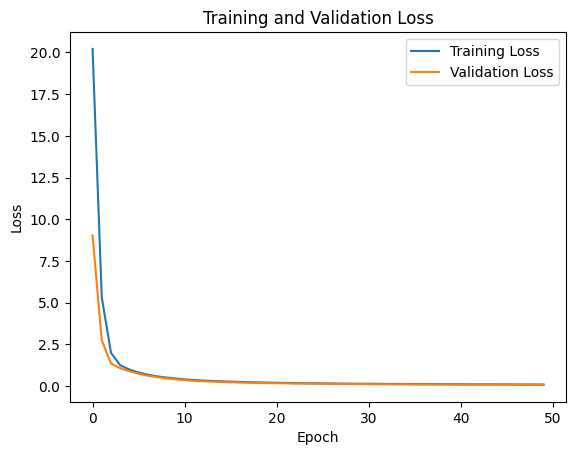

In [37]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Classifier

In [38]:
from re import X
import numpy as np
import tensorflow as tf
from tensorflow.keras.backend import expand_dims
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  LSTM, Reshape, Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input, BatchNormalization, Concatenate, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = 2

# Definimos una red CNN simple
def cnn_simple(input_layer):
    x = tf.keras.layers.Reshape((window_size, 1))(input_layer)

    # Primera capa convolucional con BatchNormalization
    x = tf.keras.layers.Conv1D(32, kernel_size=9, activation='linear', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    ## Segunda capa convolucional
    x = tf.keras.layers.Conv1D(128, kernel_size=9, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.ActivityRegularization(l1=0.004)(x)

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

def classifier(enco):
    x = enco
    x = Dense(100, activation='linear')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

# Definir la LSTM
def lstm_function(input_layer, kernel):
    lstm_input = Reshape((window_size, 1))(input_layer)

    # Capa LSTM con regularización L2
    lstm_output = LSTM(kernel, return_sequences=False)(lstm_input)

    lstm_output = BatchNormalization()(lstm_output)  # Añadir BatchNormalization

    lstm_output = Dense(50, activation='linear')(lstm_output)


    return lstm_output

def fc(enco):

    x = enco

    x = Flatten()(x)

    return x

encode = tf.keras.models.Model(inputs=autoencoder.input,
                               outputs=autoencoder.get_layer('bottleneck').output)

# Pasar la misma entrada por la red CNN simple
cnn_output = cnn_simple(data_input)

lstm_output = lstm_function(data_input, 100)
lstm_output_2 = lstm_function(data_input, 150)


# Concatenar las salidas del encoder y de la CNN
concatenated_output = Concatenate()([fc(encode.output), cnn_output, lstm_output,cnn_output, lstm_output_2])


# Crear el modelo completo
full_model = Model(inputs=data_input, outputs=classifier(concatenated_output))
encode = tf.keras.models.Model(data_input, encode.output)

# Freeze the layers in the encoder model
for layer in encode.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_encoded = full_model.predict(X_train_noisy)
X_val_encoded = full_model.predict(X_val_noisy)

# Reducir la tasa de aprendizaje en caso de estancamiento
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Early Stopping para evitar sobreentrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo
classifier_history = full_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],  # Activar ReduceLROnPlateau y EarlyStopping
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluar el modelo
loss, accuracy = full_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8144 - loss: 2122.2383 - val_accuracy: 0.8987 - val_loss: 235.8483 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9289 - loss: 919.3910 - val_accuracy: 0.8613 - val_loss: 140.8365 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9576 - loss: 136.2636 - val_accuracy: 0.8207 - val_loss: 245.7732 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9623 - loss: 19.3652 - val_accuracy: 0.8493 - val_loss: 191.5086 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9660 - loss: 9.2782 - val_accuracy: 0.9273 - val_loss: 155.4351 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9616 - loss: 3.5745 - val_accuracy: 0.9740 - val_loss: 122.8166 - learning_rate: 



```
test 1:
Loss: 0.30542847514152527, Accuracy: 0.8826666474342346
learning_rate=0.00001 y 2 lstm 200 concatenadas

test 2:
Loss: 0.33050575852394104, Accuracy: 0.8646666407585144
learning_rate=0.00001 y 2 lstm 200 en paralelo

test 3:
Loss: 0.3078058063983917, Accuracy: 0.9013333320617676
learning_rate=0.00001 y 2 lstm 200 en paralelo sin dropout en classifier

test 4:
Loss: 0.2487962245941162, Accuracy: 0.9166666865348816
learning_rate=0.0001 (variable early stop) y 1 lstm 100 en paralelo sin dropout en classifier, batch_size= 128

test 5:
Loss: 0.2204454094171524, Accuracy: 0.9240000247955322
learning_rate=0.0001 (variable early stop) y 1 lstm 150 en paralelo sin dropout en classifier, batch_size= 64

test 6:
Loss: 0.24736903607845306, Accuracy: 0.9206666946411133
learning_rate=5.0000e-05 (variable early stop) y 1 lstm 150 en paralelo sin dropout en classifier, batch_size= 128

test 7:
Loss: 0.28182438015937805, Accuracy: 0.9046666622161865
learning_rate=1.2500e-05 (variable early stop) y 1 lstm 150 en paralelo sin dropout en classifier, batch_size= 128, cambiaron filtros de la cnn en paralelo a 32 y 64 de las conv1

test 8:
Loss: 0.25032851099967957, Accuracy: 0.9179999828338623
learning_rate=1.2500e-05 (variable early stop) y 1 lstm 150 en paralelo sin dropout en classifier, batch_size= 128, cambiaron filtros de la cnn en paralelo a 64 y 128 de las conv1


```



# ROC CURVE

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


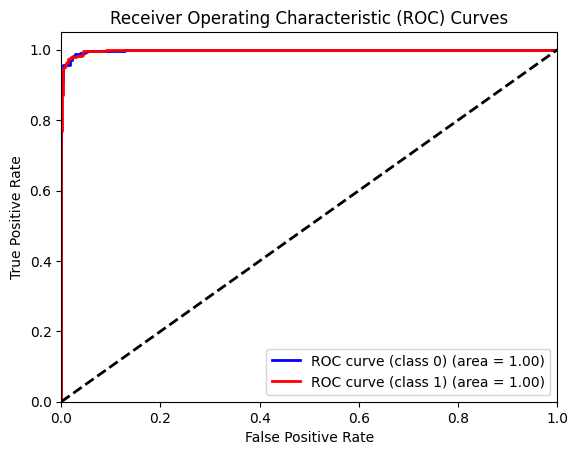

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# classes
classes = [0, 1]
# Binarize the labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=classes)

# Get the predicted probabilities from the full model
y_score = full_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


# Grafica de perdida y precision del clasificador

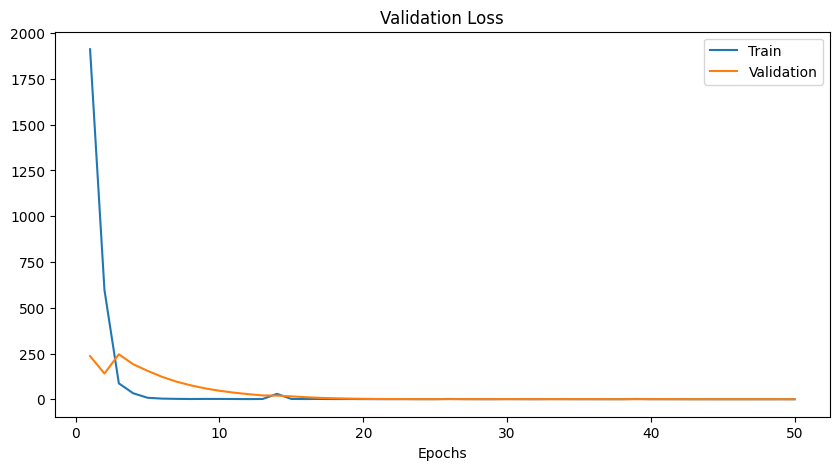

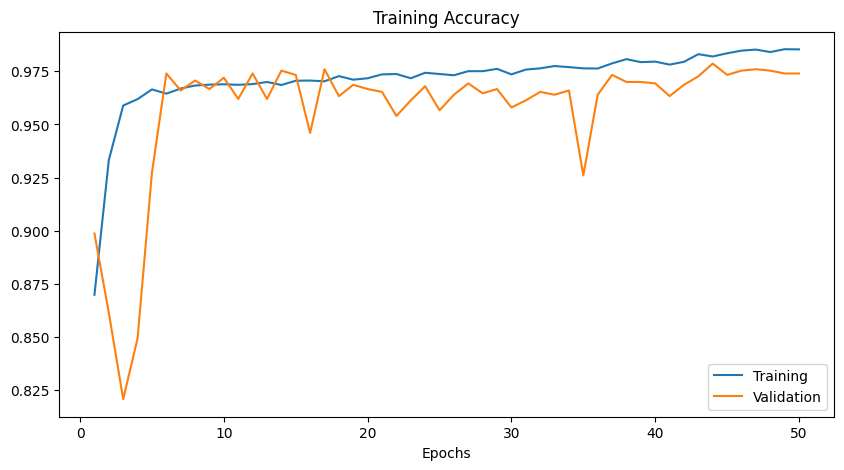

In [40]:
import matplotlib.pyplot as plt

# Plotting validation accuracy and validation loss on the same graph
plt.figure(figsize=(10, 5))
epochs = range(1, len(classifier_history.history['val_loss']) + 1)

plt.plot(epochs, classifier_history.history['loss'], label='Train')
plt.plot(epochs, classifier_history.history['val_loss'], label='Validation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Plotting training accuracy and training loss on the same graph
plt.figure(figsize=(10, 5))

plt.plot(epochs, classifier_history.history['accuracy'], label='Training')
plt.plot(epochs, classifier_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Metricas

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


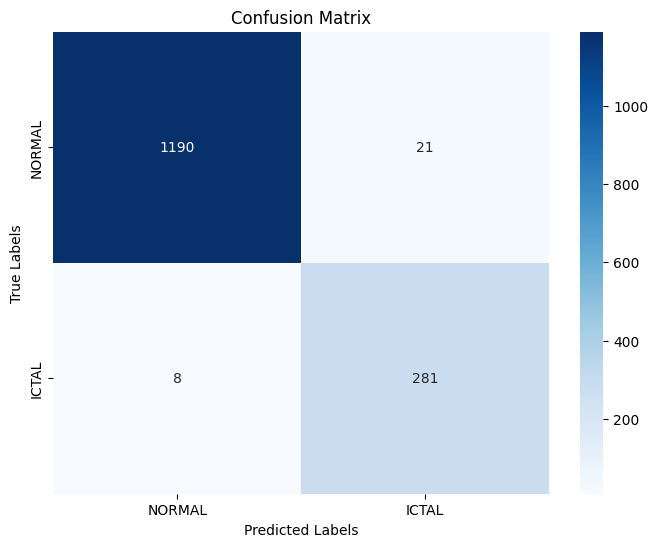

    Class  Precision  Sensitivity  Specificity  F1 Score
0  NORMAL   0.982659     0.982659     0.930464  0.987962
1   ICTAL   0.972318     0.972318     0.993322  0.950931


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 2

#label_names = ['NORMAL', 'INTERICTAL', 'ICTAL']
label_names = ['NORMAL', 'ICTAL']

# Get the predictions

y_pred_prob = full_model.predict(X_test)  # Realizar las predicciones
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Obtener la clase predicha
y_true = np.argmax(y_test, axis=1)  # Convertir las etiquetas verdaderas a clases

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=classes)

# Calculate precision for each class
precision = []
for i, label in enumerate(label_names):
    tp = cm[i, i]  # True positives
    fp = np.delete(cm[i, :], i).sum()  # False positives
    precision.append(tp / (tp + fp))

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)

# Evaluacion y verificacion cruzada

Fold 1/5
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5752 - loss: 0.8239 - val_accuracy: 0.7925 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7991 - loss: 0.4714 - val_accuracy: 0.8121 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8383 - loss: 0.4114 - val_accuracy: 0.8292 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8537 - loss: 0.3817 - val_accuracy: 0.8567 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8481 - loss: 0.3769 - val_accuracy: 0.8779 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8658 - loss: 0.3517 - val_accuracy: 0.8487 - val_loss: 0.3937 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8644 - loss:

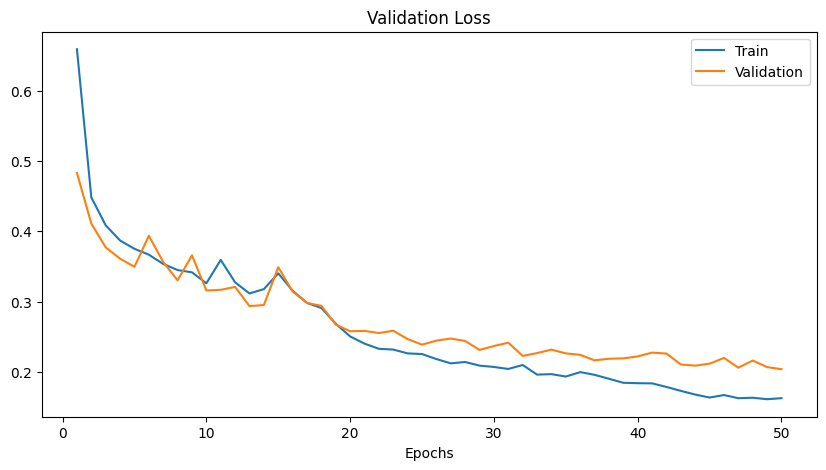

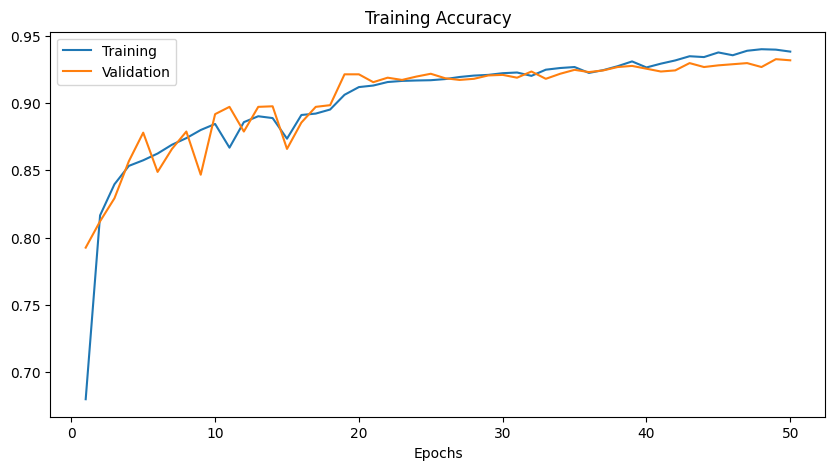

Fold 1 - Loss: 0.20366257429122925, Accuracy: 0.9316666722297668
Fold 2/5
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5845 - loss: 0.8124 - val_accuracy: 0.8554 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8058 - loss: 0.4603 - val_accuracy: 0.8775 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8323 - loss: 0.4199 - val_accuracy: 0.8938 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8409 - loss: 0.3993 - val_accuracy: 0.9121 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8600 - loss: 0.3809 - val_accuracy: 0.8350 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8551 - loss: 0.3656 - val_accuracy: 0.8808 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 7/50
15

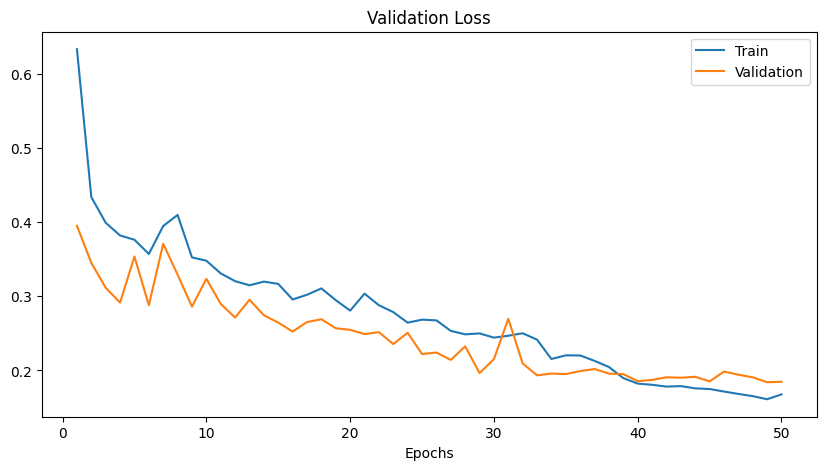

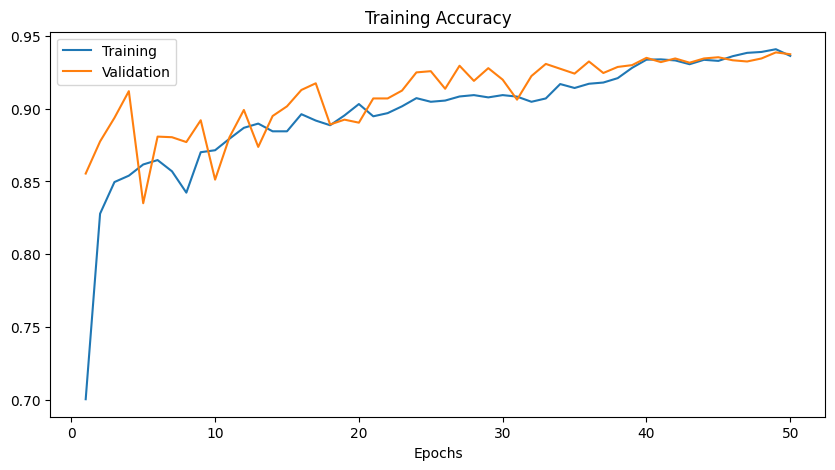

Fold 2 - Loss: 0.18407759070396423, Accuracy: 0.9387500286102295
Fold 3/5
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6044 - loss: 0.7831 - val_accuracy: 0.7400 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8073 - loss: 0.4606 - val_accuracy: 0.8233 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8489 - loss: 0.3880 - val_accuracy: 0.8258 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8627 - loss: 0.3739 - val_accuracy: 0.8629 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8715 - loss: 0.3585 - val_accuracy: 0.8892 - val_loss: 0.3508 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8684 - loss: 0.3503 - val_accuracy: 0.7792 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 7/50
15

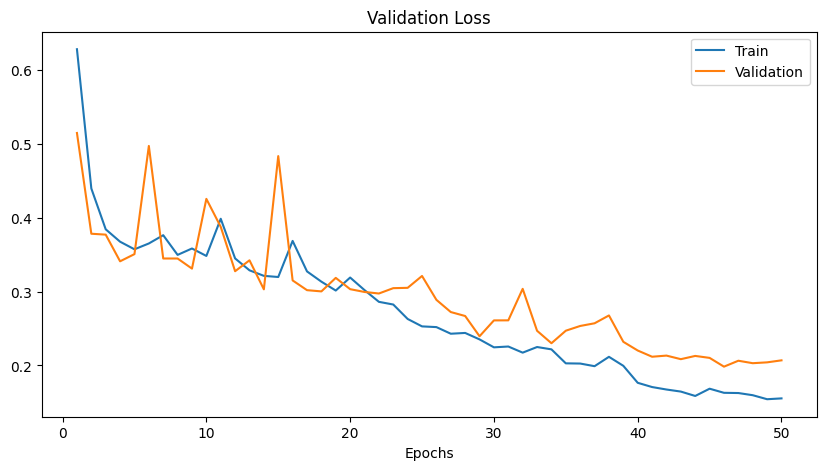

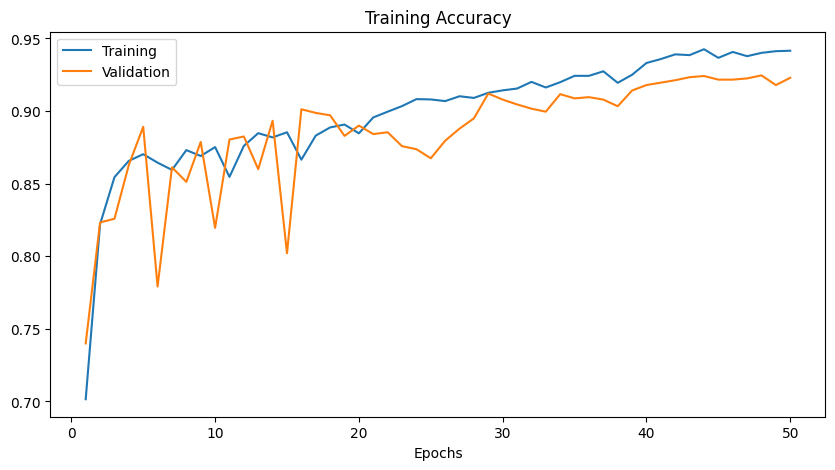

Fold 3 - Loss: 0.19836294651031494, Accuracy: 0.92166668176651
Fold 4/5
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5816 - loss: 0.8088 - val_accuracy: 0.7642 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8136 - loss: 0.4555 - val_accuracy: 0.8683 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8405 - loss: 0.4063 - val_accuracy: 0.8233 - val_loss: 0.3822 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8331 - loss: 0.4172 - val_accuracy: 0.8825 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8527 - loss: 0.3886 - val_accuracy: 0.8617 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8685 - loss: 0.3471 - val_accuracy: 0.8317 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 7/50
150/

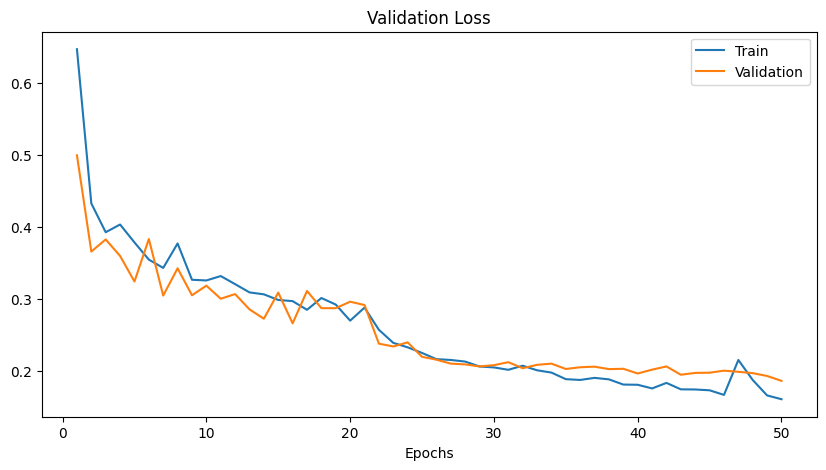

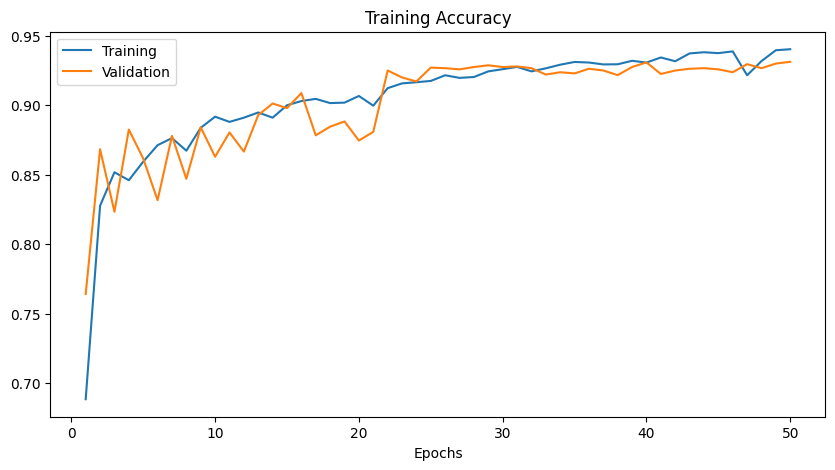

Fold 4 - Loss: 0.18581436574459076, Accuracy: 0.9312499761581421
Fold 5/5
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5569 - loss: 0.8194 - val_accuracy: 0.8346 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8139 - loss: 0.4441 - val_accuracy: 0.8783 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8506 - loss: 0.4119 - val_accuracy: 0.8800 - val_loss: 0.3508 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8514 - loss: 0.3877 - val_accuracy: 0.8946 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8674 - loss: 0.3673 - val_accuracy: 0.8875 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8689 - loss: 0.3702 - val_accuracy: 0.9042 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 7/50
15

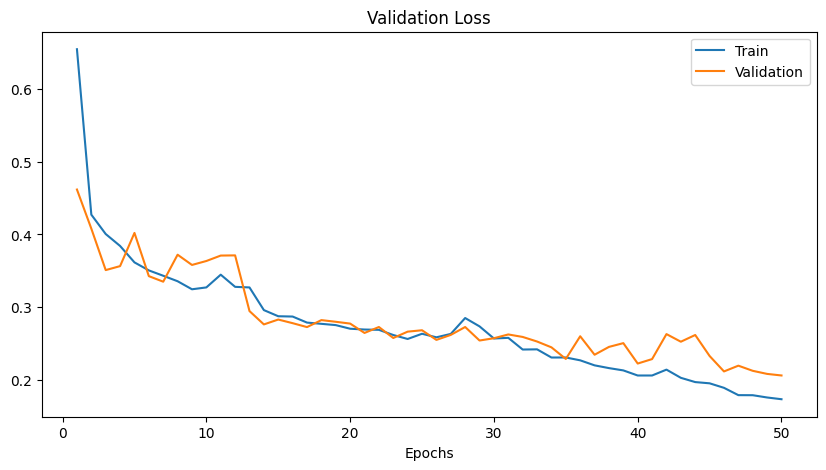

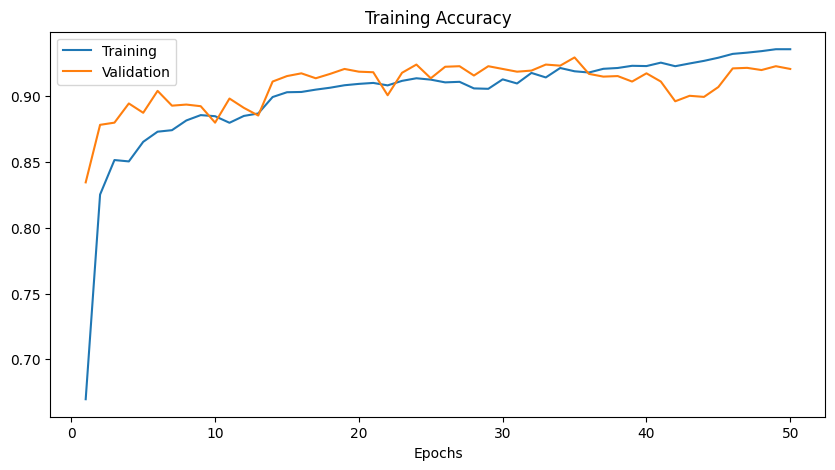

Fold 5 - Loss: 0.20562508702278137, Accuracy: 0.9208333492279053

Mean Accuracy: 0.9288 (+/- 0.0067)
Mean Loss: 0.1955 (+/- 0.0090)


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Número de folds
k_folds = 5

# Crear el generador de KFold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lista para almacenar las métricas de cada fold
fold_accuracies = []
fold_losses = []

def cnn_simple(input_layer):
    x = tf.keras.layers.Reshape((window_size, 1))(input_layer)
    #x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='linear', padding='same')(x)
    #x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    #x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='linear', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    return x

def classifier(enco):
    x = enco
    x = Dense(50, activation='linear')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x


# Definir la LSTM
def lstm_function(input_layer):
    # Reshape para que sea compatible con LSTM
    lstm_input = Reshape((window_size, 1))(input_layer)

    # Capa LSTM con 150 unidades
    lstm_output = LSTM(100, return_sequences=False)(lstm_input)

    return lstm_output

def fc(enco):

    x = enco

    x = Flatten()(x)

    return x

# Función para construir tu modelo
def build_model():
    #entrada = tf.keras.layers.Input(shape=(window_size,))

    cnn_output = cnn_simple(entrada)
    lstm_output = lstm_function(entrada)

    # Crear el encoder
    encode = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    concatenated_output = Concatenate()([fc(encode.output), cnn_output, lstm_output])

    # Crear el modelo completo
    full_model = Model(inputs=entrada, outputs=classifier(concatenated_output))

    # Congelar el encoder si es necesario
    for layer in encode.layers:
        layer.trainable = False

    # Compilar el modelo
    optimizer = Adam(learning_rate=0.001)
    full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return full_model

def generate_graphs(model_history):
  # Plotting validation accuracy and validation loss on the same graph
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(model_history.history['val_loss']) + 1)

    plt.plot(epochs, model_history.history['loss'], label='Train')
    plt.plot(epochs, model_history.history['val_loss'], label='Validation')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

    # Plotting training accuracy and training loss on the same graph
    plt.figure(figsize=(10, 5))

    plt.plot(epochs, model_history.history['accuracy'], label='Training')
    plt.plot(epochs, model_history.history['val_accuracy'], label='Validation')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

# Ejecutar K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Dividir los datos en conjuntos de entrenamiento y validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Construir el modelo usando la función build_model
    model_test = build_model()

    # Definir callbacks para este fold
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Entrenar el modelo
    history = model_test.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluar el modelo en los datos de validación de este fold
    val_loss, val_accuracy = model_test.evaluate(X_val_fold, y_val_fold)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)

    generate_graphs(history)

    print(f'Fold {fold + 1} - Loss: {val_loss}, Accuracy: {val_accuracy}')

# Calcular el promedio y desviación estándar de las métricas
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'\nMean Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})')
print(f'Mean Loss: {mean_loss:.4f} (+/- {std_loss:.4f})')

In [ ]:
full_model


<Functional name=functional_74, built=True>

# METRICAS DE ENTRENAMIENTO

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


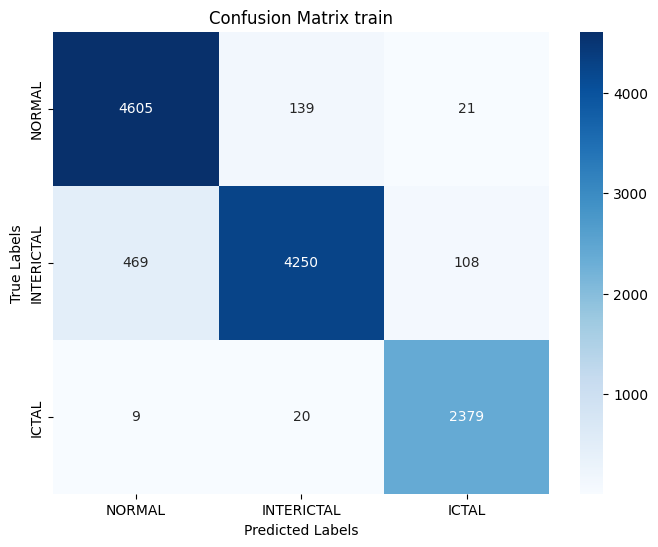

        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.966422     0.966422     0.976869  0.935215
1  INTERICTAL   0.880464     0.880464     0.923989  0.920312
2       ICTAL   0.987957     0.987957     0.996945  0.967860


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 3

label_names = ['NORMAL', 'INTERICTAL', 'ICTAL']

# Get the predictions

y_pred_prob = full_model.predict(X_train)  # Realizar las predicciones
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Obtener la clase predicha
y_true = np.argmax(y_train, axis=1)  # Convertir las etiquetas verdaderas a clases

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_train, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=[0, 1, 2])

# Calculate precision for each class
precision = []
for i, label in enumerate(label_names):
    tp = cm[i, i]  # True positives
    fp = np.delete(cm[i, :], i).sum()  # False positives
    precision.append(tp / (tp + fp))

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix train')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)

# MATRIZ VALIDACION

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


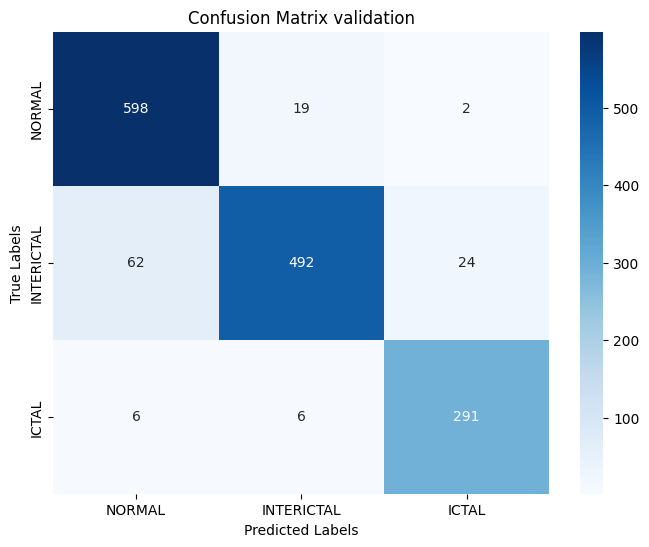

        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.966074     0.966074     0.974820  0.930739
1  INTERICTAL   0.851211     0.851211     0.912513  0.898630
2       ICTAL   0.960396     0.960396     0.989856  0.938710


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 3

label_names = ['NORMAL', 'INTERICTAL', 'ICTAL']

# Get the predictions

y_pred_prob = full_model.predict(X_val)  # Realizar las predicciones
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Obtener la clase predicha
y_true = np.argmax(y_val, axis=1)  # Convertir las etiquetas verdaderas a clases

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=[0, 1, 2])

# Calculate precision for each class
precision = []
for i, label in enumerate(label_names):
    tp = cm[i, i]  # True positives
    fp = np.delete(cm[i, :], i).sum()  # False positives
    precision.append(tp / (tp + fp))

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)